In [1]:
import torch
import os
import random
from utils import data_utils, cbm_utils, plots
import json

import cbm

In [2]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/cub_cbm_2025_09_15_09_39"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

In [3]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [4]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [5]:
accuracy = cbm_utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 24/24 [00:21<00:00,  1.11it/s]

Accuracy: 73.85%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [6]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:92 - Clark Nutcracker
Incoming weights:
A grayish or pinkish bill [0.4579] Clark Nutcracker
Other crows [0.2975] Clark Nutcracker
Other jays [0.3912] Clark Nutcracker
Reeds [-0.2310] Clark Nutcracker
Rocks [0.2952] Clark Nutcracker
Thin, pointed, grayish bill. [0.0895] Clark Nutcracker
a birdhouse [0.1334] Clark Nutcracker
a stout bill [0.1378] Clark Nutcracker
an orange jersey [0.0975] Clark Nutcracker
aquatic plants [-0.0798] Clark Nutcracker
driftwood [0.1588] Clark Nutcracker
gray head [0.0727] Clark Nutcracker
light gray belly [0.2333] Clark Nutcracker
orange and black [0.0736] Clark Nutcracker
other ravens [0.4592] Clark Nutcracker
pale greyish head [0.3764] Clark Nutcracker
plastic debris [-0.0500] Clark Nutcracker
prominent red crest [-0.4026] Clark Nutcracker
rocky cliffs [0.0589] Clark Nutcracker
rusty or reddish-brown flanks [-0.1719] Clark Nutcracker
sedges [-0.0980] Clark Nutcracker
white or yellowish head [0.1571] Clark Nutcracker
wood piles [0.1144] Clark Nu

In [7]:
to_show = random.choices([i for i in range(len(classes))], k=2)

print(len(model.final.weight[0]))
top_weights, top_weight_ids = torch.topk(model.final.weight, k=min(5, len(model.final.weight[0])), dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=min(5, len(model.final.weight[0])), dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

396
Class 137 - Tree Swallow
Highest weights: other swallows:1.127, blue, white, and black plumage:0.417, Bright blue wings and back:0.272, a birdhouse:0.241, Kingfisher:0.219, 
Lowest weights: orange face and breast patch:-0.273, dark streaking on the flanks:-0.168, a wire:-0.154, streaky brown plumage:-0.069, power lines:-0.046, 

Class 142 - Caspian Tern
Highest weights: slender red bill:0.415, a slender, orange bill:0.325, tern:0.241, red legs:0.233, other terns:0.227, 
Lowest weights: medium-sized sparrow build:-0.427, Medium-sized songbird build:-0.387, Medium-sized duck body.:-0.341, brown upperparts:-0.280, Duck-like body shape:-0.200, 



In [8]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:393/396


## Explain model reasoning for random inputs

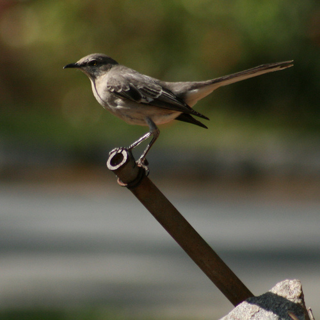

Image:2584 Gt:Mockingbird, 1st Pred:Mockingbird, 4.699, 2nd Pred:Bewick Wren, 2.730
tensor([ 0.0000,  0.0000,  0.3915,  0.5499, -0.0000, -0.0000,  0.0000,  0.0000,
        -0.0476,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
         0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.1873,  0.0000, -0.0000,
        -0.0000,  0.0000, -0.0000,  0.1107, -0.0000,  0.6147,  0.0000,  0.6859,
         0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
         0.0083, -0.0000, -0.0000, -0.0000,  1.1049, -0.0000, -0.0115, -0.0000,
        -0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
         0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0042,
        -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
        -0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -

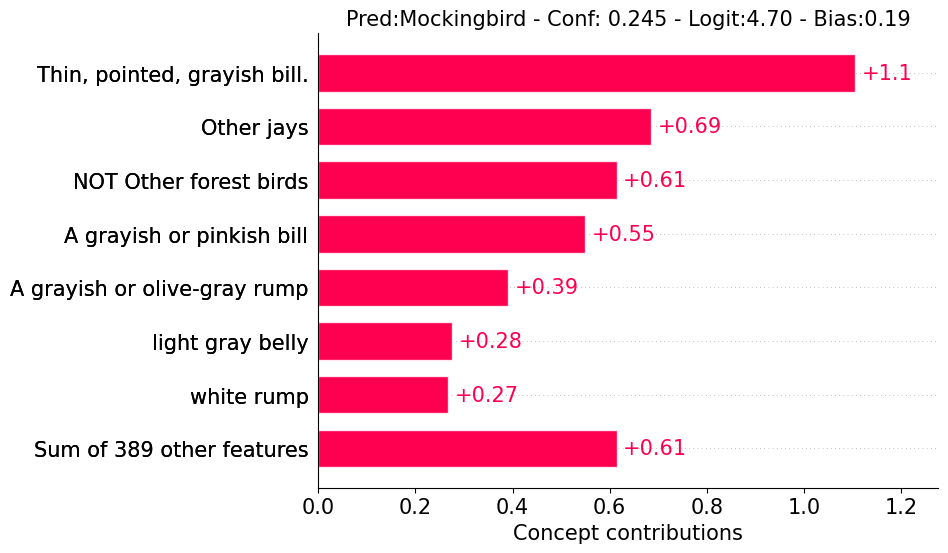

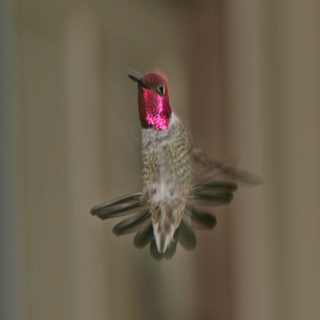

Image:1868 Gt:Anna Hummingbird, 1st Pred:Anna Hummingbird, 6.138, 2nd Pred:Rufous Hummingbird, 4.014
tensor([-0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
        0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
        -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
        -0.0000, 0.0917, 1.6919, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000,
        0.0851, -0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000,
        0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
        0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.9218, 0.0000, -0.0000,
        0.1645, -0.0000, -0.0000, 0.0000, -0.

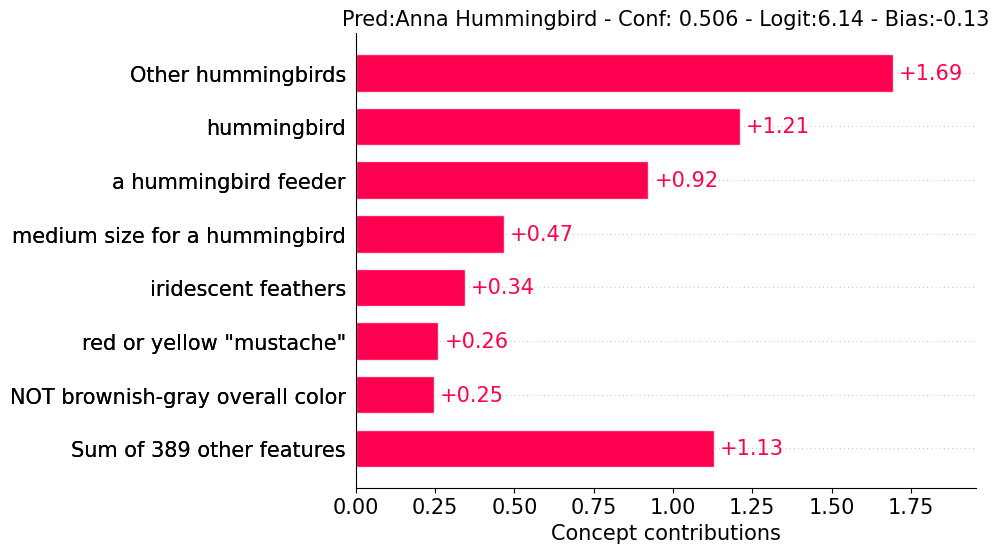

In [9]:
do_print=False
num_display=2
if do_print: num_display=1

to_display = random.sample([i for i in range(len(val_pil_data))], k=num_display)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            #print(contributions, concept_act[0], model.final.weight[top_classes[k], :])
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=15, do_print=do_print)

In [10]:
##### Section for saving image and plot as a single image ####
# from PIL import Image
#
# # Load
# img = image
# plot = Image.open("test\\feature_importances.png")
#
# # Match heights
# h = max(img.height, plot.height)
#
# # Resize keeping aspect ratio
# img_resized = img.resize((int(img.width * h / img.height), h))
# plot_resized = plot.resize((int(plot.width * h / plot.height), h))
#
# # Create combined canvas
# combined_w = img_resized.width + plot_resized.width
# combined = Image.new("RGB", (combined_w, h), (255, 255, 255))
#
# # Paste side-by-side
# combined.paste(img_resized, (0, 0))
# combined.paste(plot_resized, (img_resized.width, 0))
#
# combined.save("test\\features_combined.png")

In [11]:
train_d_probe = dataset+"_train"
cls_file = data_utils.LABEL_FILES[dataset]

train_data_t = data_utils.get_data(train_d_probe, preprocess=target_preprocess)
train_pil_data = data_utils.get_data(train_d_probe)

In [12]:
accuracy = cbm_utils.get_accuracy_cbm(model, train_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 24/24 [00:20<00:00,  1.17it/s]

Accuracy: 100.00%


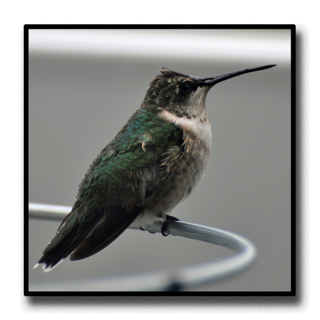

Image:2026 Gt:Ruby throated Hummingbird, 1st Pred:Ruby throated Hummingbird, 8.943, 2nd Pred:Anna Hummingbird, 4.545


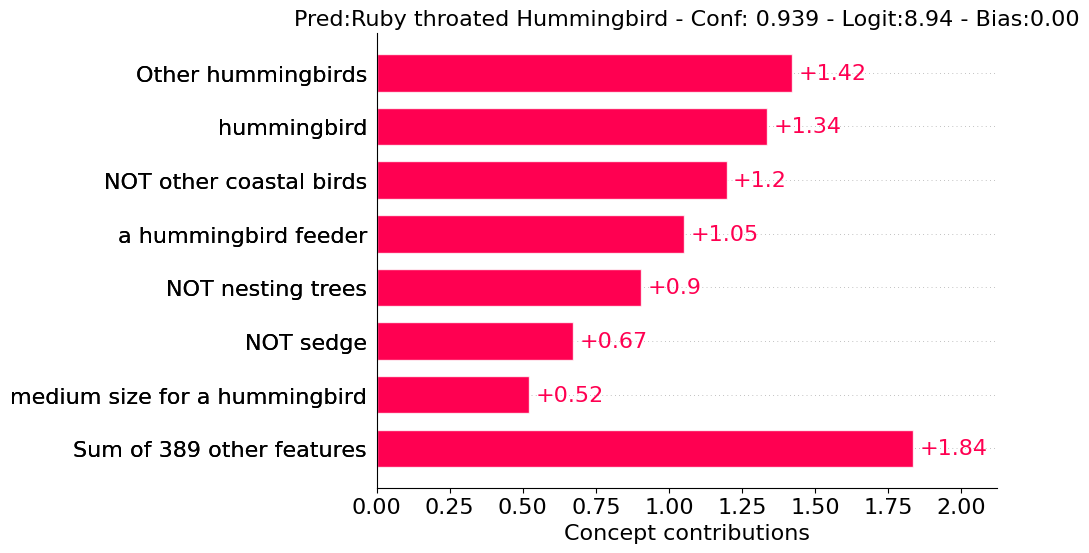

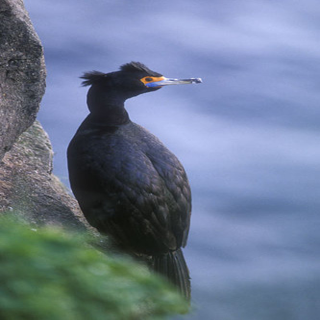

Image:703 Gt:Red faced Cormorant, 1st Pred:Red faced Cormorant, 10.601, 2nd Pred:Brandt Cormorant, 6.284


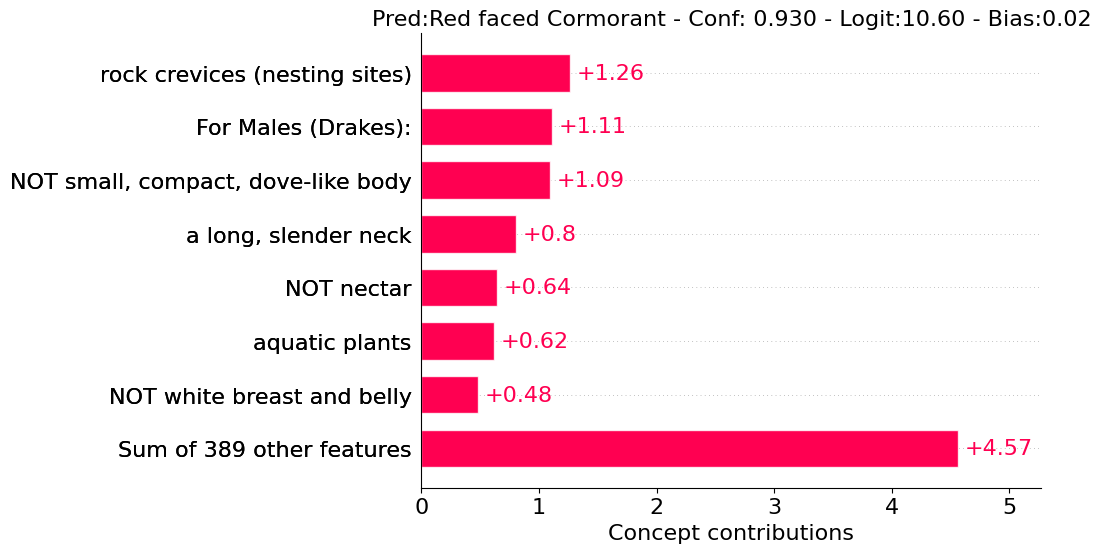

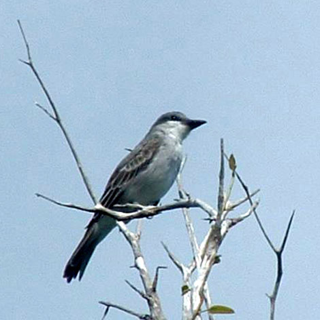

Image:2327 Gt:Gray Kingbird, 1st Pred:Gray Kingbird, 8.847, 2nd Pred:Olive sided Flycatcher, 4.145


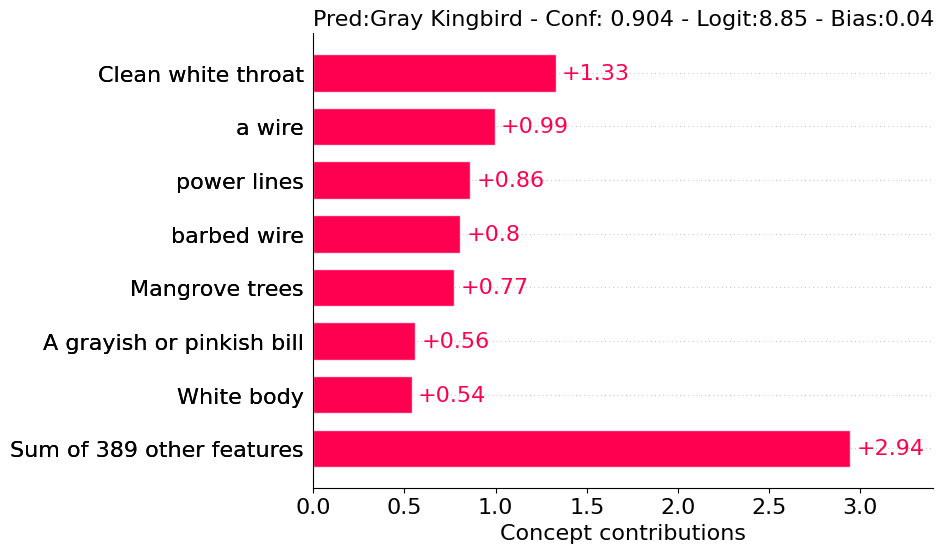

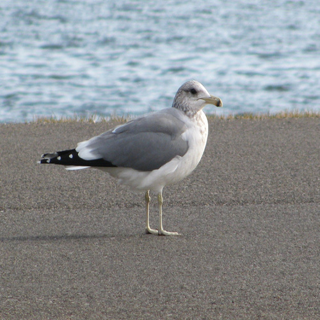

Image:1758 Gt:California Gull, 1st Pred:California Gull, 10.905, 2nd Pred:Herring Gull, 6.099


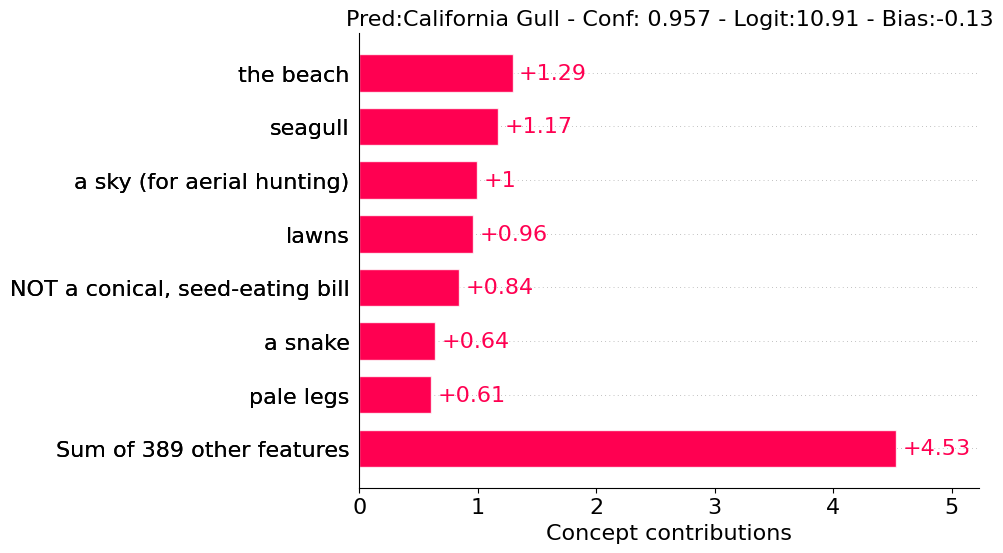

In [13]:
to_display = random.sample([i for i in range(len(train_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = train_pil_data[i]
        x, _ = train_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))

        outputs, concept_act = model(x)

        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)